In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import log_loss
from xgboost import XGBRegressor

##**Business Understanding**

The objective of building a model to predict the next month's credit card balance is to assist banking clients in financial planning and identifying risks for customers.

##**Data Acquisition**

The data for this problem statement comes from a Kaggle dataset titled Credit Card Balance Prediction.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip "/content/drive/MyDrive/balance.zip" -d "/content"

Archive:  /content/drive/MyDrive/balance.zip
  inflating: /content/CreditCardBalance.csv  


In [7]:
!ls -l /content/

total 36
-rw-r--r-- 1 root root 26585 Jul 13  2022 CreditCardBalance.csv
drwx------ 5 root root  4096 Aug  8 17:03 drive
drwxr-xr-x 1 root root  4096 Aug  6 13:39 sample_data


In [8]:
df = pd.read_csv('/content/CreditCardBalance.csv')

##**Data Cleaning & Preprocessing**

In [10]:
print(df.head())

   Unnamed: 0   Income  Limit  Rating  Cards  Age  Education  Gender Student  \
0           1   14.891   3606     283      2   34         11    Male      No   
1           2  106.025   6645     483      3   82         15  Female     Yes   
2           3  104.593   7075     514      4   71         11    Male      No   
3           4  148.924   9504     681      3   36         11  Female      No   
4           5   55.882   4897     357      2   68         16    Male      No   

  Married  Ethnicity  Balance  
0     Yes  Caucasian      333  
1     Yes      Asian      903  
2      No      Asian      580  
3      No      Asian      964  
4     Yes  Caucasian      331  


In [11]:
# make target column name more clear
df.rename(columns={'Balance': 'NextMonthBalance'}, inplace=True)

# drop index column
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# fill for missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# encode categorical variables
df = pd.get_dummies(df, drop_first=True)

##**Exploratory Data Analysis & Statistical Analysis**

In [13]:
# first 5 rows
print(df.head())

    Income  Limit  Rating  Cards  Age  Education  NextMonthBalance  \
0   14.891   3606     283      2   34         11               333   
1  106.025   6645     483      3   82         15               903   
2  104.593   7075     514      4   71         11               580   
3  148.924   9504     681      3   36         11               964   
4   55.882   4897     357      2   68         16               331   

   Gender_Female  Student_Yes  Married_Yes  Ethnicity_Asian  \
0          False        False         True            False   
1           True         True         True             True   
2          False        False        False             True   
3           True        False        False             True   
4          False        False         True            False   

   Ethnicity_Caucasian  
0                 True  
1                False  
2                False  
3                False  
4                 True  


In [14]:
# column data types
print(df.dtypes)

Income                 float64
Limit                    int64
Rating                   int64
Cards                    int64
Age                      int64
Education                int64
NextMonthBalance         int64
Gender_Female             bool
Student_Yes               bool
Married_Yes               bool
Ethnicity_Asian           bool
Ethnicity_Caucasian       bool
dtype: object


In [15]:
# summary statistics
print(df.describe(include='all'))

            Income         Limit      Rating       Cards         Age  \
count   400.000000    400.000000  400.000000  400.000000  400.000000   
unique         NaN           NaN         NaN         NaN         NaN   
top            NaN           NaN         NaN         NaN         NaN   
freq           NaN           NaN         NaN         NaN         NaN   
mean     45.218885   4735.600000  354.940000    2.957500   55.667500   
std      35.244273   2308.198848  154.724143    1.371275   17.249807   
min      10.354000    855.000000   93.000000    1.000000   23.000000   
25%      21.007250   3088.000000  247.250000    2.000000   41.750000   
50%      33.115500   4622.500000  344.000000    3.000000   56.000000   
75%      57.470750   5872.750000  437.250000    4.000000   70.000000   
max     186.634000  13913.000000  982.000000    9.000000   98.000000   

         Education  NextMonthBalance Gender_Female Student_Yes Married_Yes  \
count   400.000000        400.000000           400       

##**Feature Engineering**

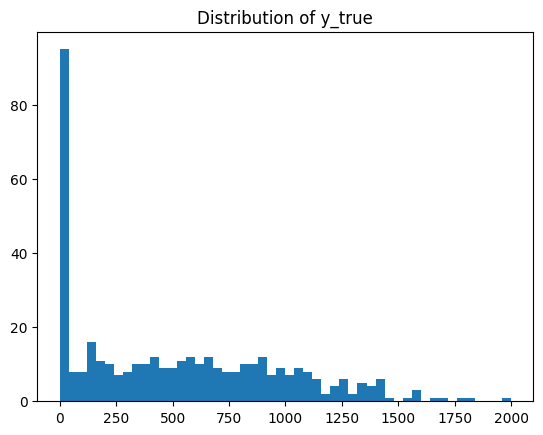

In [16]:
# split features
# balance for next month is target column
y = df['NextMonthBalance']
plt.hist(y, bins=50)
plt.title("Distribution of y_true")
plt.show()
# X is all other features
X = df.drop(columns=['NextMonthBalance'])

In [17]:
# dataframe after data cleaning & preprocessing and feature engineering
print(df)

      Income  Limit  Rating  Cards  Age  Education  NextMonthBalance  \
0     14.891   3606     283      2   34         11               333   
1    106.025   6645     483      3   82         15               903   
2    104.593   7075     514      4   71         11               580   
3    148.924   9504     681      3   36         11               964   
4     55.882   4897     357      2   68         16               331   
..       ...    ...     ...    ...  ...        ...               ...   
395   12.096   4100     307      3   32         13               560   
396   13.364   3838     296      5   65         17               480   
397   57.872   4171     321      5   67         12               138   
398   37.728   2525     192      1   44         13                 0   
399   18.701   5524     415      5   64          7               966   

     Gender_Female  Student_Yes  Married_Yes  Ethnicity_Asian  \
0            False        False         True            False   
1    

##**Model Training**

We first train a Random Forest Regression using a 10-fold cross validation and pick the best model to minimize the RMSE

In [18]:
# split into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

y_train_val = np.log1p(y_train_val)
# train random forest regression model
model1 = RandomForestRegressor(random_state=42)
param_dist1 = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search1 = RandomizedSearchCV(
    estimator=model1,
    param_distributions=param_dist1,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search1.fit(X_train_val, y_train_val)

best_model1 = random_search1.best_estimator_
y_pred_log1 = best_model1.predict(X_test)
y_pred1 = np.expm1(y_pred_log1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


We first train an XGBoost Regression using a 10-fold cross validation and pick the best model to minimize the RMSE. This is especially important for an XGB model, which is prone to overfitting

In [19]:
#train xgboost regression model
model2 = XGBRegressor(objective='reg:squarederror', random_state=42)
param_dist2 = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_dist2,
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search2.fit(X_train_val, y_train_val)

best_model2 = random_search2.best_estimator_
y_pred_log2 = best_model2.predict(X_test)
y_pred2 = np.expm1(y_pred_log2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:07:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##**Model Evaluation & Explainability**

The R^2 values for both models are very good over all the runs. Both RMSE values are acceptable, but the XGBoost model performs much better according to this metric. This is because the target column values are highly skewed with a right tail. The XGBoost model is more robust under these conditions, especially when fine-tuned.

In [20]:
# model evaluation
r21 = r2_score(y_test, y_pred1)
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
print(f"R2 Score Random Forest: {r21:.4f}")
print(f"RMSE Random Forest: {rmse1:.4f}")
r22 = r2_score(y_test, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
print(f"\nR2 Score XGB: {r22:.4f}")
print(f"RMSE XGB: {rmse2:.4f}")

R2 Score Random Forest: 0.9059
RMSE Random Forest: 125.4143

R2 Score XGB: 0.9348
RMSE XGB: 104.3339


As we can see through the scatter plots and calibration curves, the XGBoost model leads to more accurate predictions.

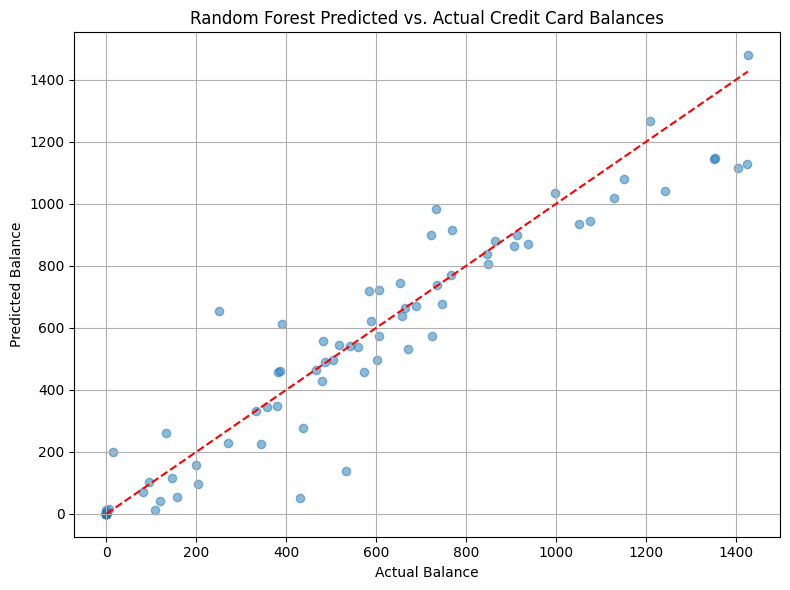

In [23]:
# scatter plot of predicted vs. actual credit card balances
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Balance')
plt.ylabel('Predicted Balance')
plt.title('Random Forest Predicted vs. Actual Credit Card Balances')
plt.grid(True)
plt.tight_layout()
plt.savefig("probability_scatter_rf.png")
plt.show()

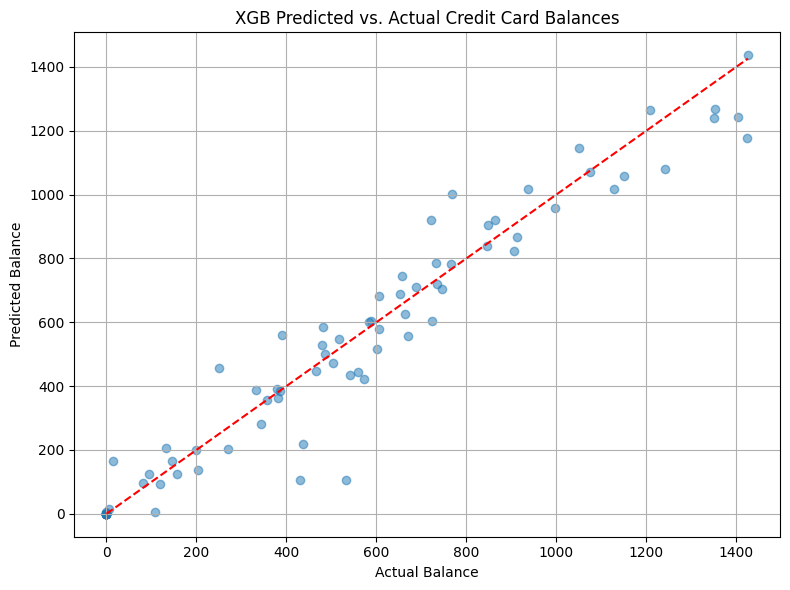

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Balance')
plt.ylabel('Predicted Balance')
plt.title('XGB Predicted vs. Actual Credit Card Balances')
plt.grid(True)
plt.tight_layout()
plt.savefig("probability_scatter_xgbr.png")
plt.show()

In [31]:
# create function for calibration curve
def calibration_curve(y_true, y_pred, n_bins=10, title="Calibration Curve (Binned Means)"):
    # make dataframe with true and predicted values from regression model
    df_plot = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    # put predicted values in equal size bins
    df_plot['bin'] = pd.qcut(df_plot['y_pred'], q=n_bins, duplicates='drop')
    # find average predicted and average real values for each bin
    bin_means = df_plot.groupby('bin').agg({
        'y_pred': 'mean', # average predicted values
        'y_true': 'mean' # average true values
    })

    # plot calibration curve of predicted value vs. actual value for each bin
    plt.figure(figsize=(8, 6))
    # add trend marker
    plt.plot(bin_means['y_pred'], bin_means['y_true'], marker='o', label='Binned Average')
    # this represents perfect prediction (actual values)
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], '--r', label='Ideal')
    plt.xlabel("Mean Predicted Balance")
    plt.ylabel("Mean Actual Balance")
    plt.title(title)
    plt.grid(True)
    plt.legend()

    return plt

/tmp/ipython-input-1955847732.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby('bin').agg({


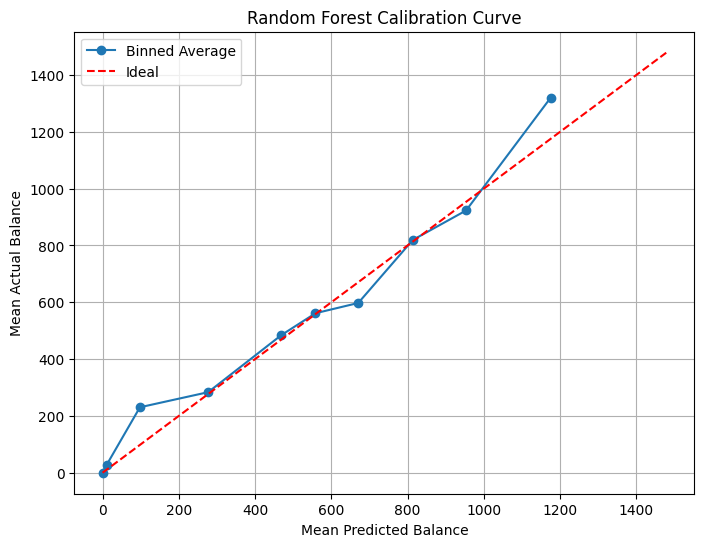

In [34]:
calibration_curve_rf = calibration_curve(y_test, y_pred1, title="Random Forest Calibration Curve")
calibration_curve_rf.savefig("calibration_curve_rf.png")
calibration_curve_rf.show()

/tmp/ipython-input-1955847732.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby('bin').agg({


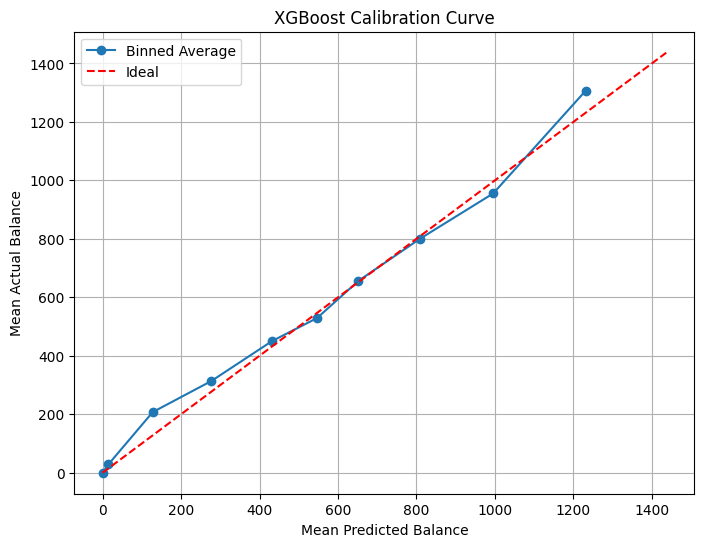

In [35]:
calibration_curve_xgbr = calibration_curve(y_test, y_pred2, title="XGBoost Calibration Curve")
calibration_curve_xgbr.savefig("calibration_curve_xgbr.png")
calibration_curve_xgbr.show()

##**Monitoring & Maintenance**

The R^2 values, RMSE values, Probability Scatter Curve, and Calibration Curve for both models were logged using MLflow to track model performance across experiment runs. The end-to-end project was also wrapped in a pipeline structure and saved as a pickle file in MLflow. This part of the project was removed to streamline the workflow and focus on direct model evaluation. Pipeline storage was not essential for the final deployment of the project.